# Evaluating Word Representations

## Getting the pre-trained word vectors

In [1]:
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from scipy import stats

In [2]:
bow2_file = 'bow2.words'
bow5_file = 'bow5.words'
dependency_file = 'deps.words'

#read the files
with open(bow2_file) as f:
    bow2 = f.readlines()
    
with open(bow5_file) as f:
    bow5 = f.readlines()
    
with open(dependency_file) as f:
    dependency = f.readlines()
  

In [3]:
print(len(bow2))
print(len(bow5))
print(len(dependency))

183870
183870
174015


In [4]:
word2 = []
word5 = []
word_deps = []

vector2 = dict()
vector5 = dict()
vector_deps = dict()

In [5]:
#fill in the word arrays and the respective vector arrays

#bow2
for l in bow2:
    #split line
    split_line = str.split(l)
    
    #first one is the word - string
    word = split_line[0]
    word2.append(word)
    
    #remaining elements are the embedding values - float
    vector = []
    for vd in split_line[1:]:
        vector.append(float(vd))
        
    vector2[word] = vector
    

In [6]:
#bow5
for l in bow5:
    #split line
    split_line = str.split(l)
    
    #first one is the word - string
    word = split_line[0]
    word5.append(word)
    
    #remaining elements are the embedding values - float
    vector = []
    for vd in split_line[1:]:
        vector.append(float(vd))
        
    vector5[word] = vector

In [7]:
#dependency
for l in dependency:
    #split line
    split_line = str.split(l)
    
    #first one is the word - string
    word = split_line[0]
    word_deps.append(word)
    
    #remaining elements are the embedding values - float
    vector = []
    for vd in split_line[1:]:
        vector.append(float(vd))
        
    vector_deps[word] = vector

In [8]:
print(word2[0])
print(word5[0])
print(word_deps[0])


the
the
the


In [9]:
print(len(vector2['the']))
print(len(vector5['the']))
print(len(vector_deps['the']))


300
300
300


## Word Similarity Task

In [10]:
#natural form MEN
word_pairs = {}

filename = 'MEN/MEN_dataset_natural_form_full'

with open(filename) as f:
    lines = f.readlines()
    
for line in lines:
    line = line.split()
    word1 = line[0]
    word2 = line[1]
    score = line[2]
    word_pairs[(word1,word2)] = score
    
keys = list(word_pairs.keys())

In [11]:
def get_scores_cosines(keys, word_pairs, vector_embeds, norm_min, norm_max):
    #vector_deps and cosine similarity comparison
    scores = []
    cosines = []

    for key in keys:
        word1 = key[0]
        word2 = key[1]
        score = word_pairs[(word1,word2)]
        score = (float(score) - norm_min)/(norm_max - norm_min) #normalization
        if word1 in vector_embeds.keys() and word2 in vector_embeds.keys():
            word1_embed = vector_embeds[word1]
            word2_embed = vector_embeds[word2]
            
            cosine_similarity = 1 - spatial.distance.cosine(word1_embed, word2_embed)
#             print("Score : ",score)
#             print("Cosine similarity: ",cosine_similarity)
#             print(word1, word2)
#             print("\n")
            
            scores.append(score)
            cosines.append(cosine_similarity)
            
            
    return scores, cosines
        

In [15]:
def get_scores_cosines_not_normalize(keys, word_pairs, vector_embeds):
    #vector_deps and cosine similarity comparison
    scores = []
    cosines = []

    for key in keys:
        word1 = key[0]
        word2 = key[1]
        score = float(word_pairs[(word1,word2)])
        if word1 in vector_embeds.keys() and word2 in vector_embeds.keys():
            word1_embed = vector_embeds[word1]
            word2_embed = vector_embeds[word2]
            
            cosine_similarity = 1 - spatial.distance.cosine(word1_embed, word2_embed)
#             print("Score : ",score)
#             print("Cosine similarity: ",cosine_similarity)
#             print(word1, word2)
#             print("\n")
            
            scores.append(score)
            cosines.append(cosine_similarity)
            
            
    return scores, cosines
        

In [19]:
norm_max = 50 #for MEN
norm_min = 0 #for MEN

#normalized

#vector2 and cosine similarity comparison
scores_2, cosines_2 = get_scores_cosines(keys, word_pairs, vector2, norm_min, norm_max)

#vector5 and cosine similarity comparison
scores_5, cosines_5 = get_scores_cosines(keys, word_pairs, vector5, norm_min, norm_max)

#vector2 and cosine similarity comparison
scores_deps, cosines_deps = get_scores_cosines(keys, word_pairs, vector_deps, norm_min, norm_max)


#non-normalized
#vector2 and cosine similarity comparison
scores_2_nn, cosines_2_nn = get_scores_cosines_not_normalize(keys, word_pairs, vector2)

#vector5 and cosine similarity comparison
scores_5_nn, cosines_5_nn = get_scores_cosines_not_normalize(keys, word_pairs, vector5)

#vector2 and cosine similarity comparison
scores_deps_nn, cosines_deps_nn = get_scores_cosines_not_normalize(keys, word_pairs, vector_deps)

In [20]:
for s in range(len(scores_2)):
    print(scores_2[s], cosines_2[s], scores_2_nn[s], cosines_2_nn[s])

1.0 0.490664423778 50.0 0.490664423778
1.0 0.633347188123 50.0 0.633347188123
0.98 0.364062478897 49.0 0.364062478897
0.98 0.690323914564 49.0 0.690323914564
0.98 0.41759406951 49.0 0.41759406951
0.98 0.478284739303 49.0 0.478284739303
0.98 0.482362623007 49.0 0.482362623007
0.98 0.53356567396 49.0 0.53356567396
0.98 0.441812115712 49.0 0.441812115712
0.96 0.507460655195 48.0 0.507460655195
0.96 0.420624536852 48.0 0.420624536852
0.96 0.511143876815 48.0 0.511143876815
0.96 0.416137837905 48.0 0.416137837905
0.96 0.414085419054 48.0 0.414085419054
0.96 0.343958508467 48.0 0.343958508467
0.96 0.440699601746 48.0 0.440699601746
0.96 0.541180659686 48.0 0.541180659686
0.94 0.521611244998 47.0 0.521611244998
0.94 0.497883007538 47.0 0.497883007538
0.94 0.468377096117 47.0 0.468377096117
0.94 0.389757512699 47.0 0.389757512699
0.94 0.50750756682 47.0 0.50750756682
0.94 0.589766801399 47.0 0.589766801399
0.94 0.348481224294 47.0 0.348481224294
0.94 0.367819656269 47.0 0.367819656269
0.92 0.5

0.72 0.217645602771 36.0 0.217645602771
0.72 0.400615456138 36.0 0.400615456138
0.72 0.188577444805 36.0 0.188577444805
0.72 0.364386393748 36.0 0.364386393748
0.72 0.406907600586 36.0 0.406907600586
0.72 0.632527548311 36.0 0.632527548311
0.72 0.384879191513 36.0 0.384879191513
0.72 0.533242918557 36.0 0.533242918557
0.72 0.562909316373 36.0 0.562909316373
0.72 0.374032964268 36.0 0.374032964268
0.7 0.308559669494 35.0 0.308559669494
0.7 0.210234390001 35.0 0.210234390001
0.7 0.515740788496 35.0 0.515740788496
0.7 0.251819488548 35.0 0.251819488548
0.7 0.351768565886 35.0 0.351768565886
0.7 0.829421562376 35.0 0.829421562376
0.7 0.544398572826 35.0 0.544398572826
0.7 0.635926937991 35.0 0.635926937991
0.7 0.510289415899 35.0 0.510289415899
0.7 0.43782791026 35.0 0.43782791026
0.7 0.786963023001 35.0 0.786963023001
0.7 0.388684223408 35.0 0.388684223408
0.7 0.288146518404 35.0 0.288146518404
0.7 0.359247434367 35.0 0.359247434367
0.7 0.387343957604 35.0 0.387343957604
0.7 0.39658254016

0.42 0.312891199481 21.0 0.312891199481
0.42 0.295075007434 21.0 0.295075007434
0.42 0.211363823633 21.0 0.211363823633
0.42 0.386916074558 21.0 0.386916074558
0.42 0.148690333452 21.0 0.148690333452
0.42 0.193865868668 21.0 0.193865868668
0.42 0.11603073663 21.0 0.11603073663
0.42 0.410342003148 21.0 0.410342003148
0.42 0.32224226897 21.0 0.32224226897
0.42 0.171830841053 21.0 0.171830841053
0.42 0.168801698966 21.0 0.168801698966
0.42 0.277631878214 21.0 0.277631878214
0.42 0.262761096723 21.0 0.262761096723
0.42 0.150331972388 21.0 0.150331972388
0.42 0.18706617205 21.0 0.18706617205
0.42 0.293532751652 21.0 0.293532751652
0.42 0.189517788742 21.0 0.189517788742
0.42 0.0743555260105 21.0 0.0743555260105
0.42 0.289470863219 21.0 0.289470863219
0.42 0.117748052263 21.0 0.117748052263
0.42 0.430899097986 21.0 0.430899097986
0.42 0.288887454353 21.0 0.288887454353
0.42 0.196771414868 21.0 0.196771414868
0.42 0.308486575844 21.0 0.308486575844
0.42 0.0961963893326 21.0 0.0961963893326
0.

0.16 0.205647763217 8.0 0.205647763217
0.16 0.339199049154 8.0 0.339199049154
0.16 0.187835176288 8.0 0.187835176288
0.16 0.201200750382 8.0 0.201200750382
0.16 0.083085333571 8.0 0.083085333571
0.16 0.269102162081 8.0 0.269102162081
0.16 0.279578921134 8.0 0.279578921134
0.16 0.218236103277 8.0 0.218236103277
0.16 0.213989582187 8.0 0.213989582187
0.16 0.195098904863 8.0 0.195098904863
0.16 0.152079379327 8.0 0.152079379327
0.16 0.229194076281 8.0 0.229194076281
0.16 0.310463428178 8.0 0.310463428178
0.16 0.144743709099 8.0 0.144743709099
0.16 0.101817521885 8.0 0.101817521885
0.16 0.209346622059 8.0 0.209346622059
0.16 0.170683159369 8.0 0.170683159369
0.16 0.195584560337 8.0 0.195584560337
0.16 0.0883941204989 8.0 0.0883941204989
0.16 0.138358868682 8.0 0.138358868682
0.16 0.138195640607 8.0 0.138195640607
0.16 0.331779212495 8.0 0.331779212495
0.16 0.353330527144 8.0 0.353330527144
0.16 0.0865032645596 8.0 0.0865032645596
0.14 0.158565763412 7.0 0.158565763412
0.14 0.126065967397 7

In [29]:
print(pearsonr(scores_2, cosines_2))
print(pearsonr(scores_2_nn, cosines_2_nn))

print(spearmanr(scores_2, cosines_2))
print(spearmanr(scores_2_nn, cosines_2_nn))

(0.67769822446992301, 0.0)
(0.67769822446992301, 0.0)
SpearmanrResult(correlation=0.69990475583081901, pvalue=0.0)
SpearmanrResult(correlation=0.69990475583081901, pvalue=0.0)


In [13]:
def get_stats(cosines_2, scores_2, cosines_5, scores_5, cosines_deps, scores_deps):
    cosines_2 = np.asarray(cosines_2)
    cosines_5 = np.asarray(cosines_5)
    cosines_deps = np.asarray(cosines_deps)

    mean_cos_2 = np.mean(cosines_2)
    std_cos_2 = np.std(cosines_2)

    mean_cos_5 = np.mean(cosines_5)
    std_cos_5 = np.std(cosines_5)

    mean_cos_deps = np.mean(cosines_deps)
    std_cos_deps= np.std(cosines_deps)

    print('Means and stds')
    print('Bow2:',mean_cos_2, std_cos_2)
    print('Bow5:',mean_cos_5, std_cos_5)
    print('Deps:',mean_cos_deps, std_cos_deps)
    
    print()
    
    #normality tests means sds
    print('Normality tests')
    print('Bow2 scores:',stats.normaltest(scores_2)[1])
    print('Bow5 scores:',stats.normaltest(scores_5)[1])
    print('Deps scores:',stats.normaltest(scores_deps)[1])
    print()
    print('Bow2 cosines:',stats.normaltest(cosines_2)[1])
    print('Bow5 cosines:',stats.normaltest(cosines_5)[1])
    print('Deps cosines:',stats.normaltest(cosines_deps)[1])
    print()
    
    #difference between the embed types cosine similarities
    print('T-test between Bow2 and Bow5')
    print(stats.ttest_ind(cosines_2, cosines_5)[1])
    print('T-test between Bow2 and Dependency')
    print(stats.ttest_ind(cosines_2, cosines_deps)[1])
    print('T-test between Dependency and Bow2')
    print(stats.ttest_ind(cosines_deps, cosines_5)[1])
    print()
    
    #difference between the embed types cosine similarities vs human ratings
    print('T-test between Bow2 and human scores')
    print(stats.ttest_ind(cosines_2, scores_2)[1])
    print('T-test between Bow5 and human scores')
    print(stats.ttest_ind(cosines_5, scores_5)[1])
    print('T-test between Dependency and human scores')
    print(stats.ttest_ind(cosines_deps, scores_deps)[1])
    print()
    
    #correlation tests for bow2
    pr_2, sig_p_2 = pearsonr(scores_2, cosines_2)
    spr_2, sig_s_2 = spearmanr(scores_2, cosines_2)

    print('Correlation results for BOW2 vs. human ratings')
    print('Pearson\'s r:',pr_2, 'p-value =', sig_p_2)
    print('Spearman\'s r:',spr_2, 'p-value =', sig_s_2)
    print()
    ###

    #correlation tests for bow5
    pr_5, sig_p_5 = pearsonr(scores_5, cosines_5)
    spr_5, sig_s_5 = spearmanr(scores_5, cosines_5)

    print('Correlation results for BOW5 vs. human ratings')
    print('Pearson\'s r:',pr_5, 'p-value =', sig_p_5)
    print('Spearman\'s r:',spr_5, 'p-value =', sig_s_5)
    print()

    ###
    #correlation tests for dependency
    pr_deps, sig_p_deps = pearsonr(scores_deps, cosines_deps)
    spr_deps, sig_s_deps = spearmanr(scores_deps, cosines_deps)

    print('Correlation results for Dependency vs. human ratings')
    print('Pearson\'s r:',pr_deps, 'p-value =', sig_p_deps)
    print('Spearman\'s r:',spr_deps, 'p-value =', sig_s_deps)

In [14]:
len(cosines_2)

3000

In [15]:
print(get_pair_count(keys, vector2), get_pair_count(keys, vector5),get_pair_count(keys, vector_deps))

NameError: name 'get_pair_count' is not defined

In [ ]:
print('***Stats for MEN natural form***')
get_stats(cosines_2, scores_2, cosines_5, scores_5, cosines_deps, scores_deps)

In [ ]:
#lemmatized MEN, which includes POS-tags and words with inflections 

word_pairs = {}
pos_tag_pairs = {}

filename = 'MEN/MEN_dataset_lemma_form_full'

with open(filename) as f:
    lines = f.readlines()
    
for line in lines:
    line = line.split()
    
    word_pos_1 = line[0]
    split_wp = word_pos_1.split('-')
    word1 = split_wp[0]
    pos1 = split_wp[1]
    
    word_pos_2 = line[1]
    split_wp = word_pos_2.split('-')
    word2= split_wp[0]
    pos2 = split_wp[1]
    
    score = line[2]
    word_pairs[(word1,word2)] = score
    pos_tag_pairs[(word1, word2)] = (pos1, pos2)
    
keys = list(word_pairs.keys())

In [ ]:
keys[0]

In [ ]:
pos_tag_pairs[('sun', 'sunlight')]

In [ ]:
len(cosines_2)

In [ ]:
print(get_pair_count(keys, vector2), get_pair_count(keys, vector5),get_pair_count(keys, vector_deps))

In [ ]:
def get_pair_count(keys, vector_embeds):
    count = 0
    
    for key in keys:
        word1 = key[0]
        word2 = key[1]
        if word1 in vector_embeds.keys() and word2 in vector_embeds.keys():
            count = count + 1
        else:
            print(word1, word2)
           
    return count

In [ ]:
vector2['stairs'] #natural form exists in the embeddings

In [ ]:
#vector2 and cosine similarity comparison
scores_2, cosines_2 = get_scores_cosines(keys, word_pairs, vector2, norm_min, norm_max)

#vector5 and cosine similarity comparison
scores_5, cosines_5 = get_scores_cosines(keys, word_pairs, vector5, norm_min, norm_max)

#vector2 and cosine similarity comparison
scores_deps, cosines_deps = get_scores_cosines(keys, word_pairs, vector_deps, norm_min, norm_max)

print('***Stats for MEN lemma form***')
get_stats(cosines_2, scores_2, cosines_5, scores_5, cosines_deps, scores_deps)

In [ ]:
#TODO SOMETHING ABOUT POS-TAGS *** 

In [ ]:
# Simlex Dataset Read

word_pairs = {}

filename = 'SimLex-999/SimLex-999.txt'

with open(filename) as f:
    lines = f.readlines()
    
lines = lines[1:]
for line in lines:
    line = line.split()
    word1 = line[0]
    word2 = line[1]
    score = line[3]
    word_pairs[(word1,word2)] = score
    
keys = list(word_pairs.keys())

In [ ]:
'disorganize' in vector2

In [ ]:
print(get_pair_count(keys, vector2), get_pair_count(keys, vector5),get_pair_count(keys, vector_deps))

In [ ]:
norm_min = 0 #For SimLex
norm_max = 10 #For SimLex

#vector2 and cosine similarity comparison
scores_2, cosines_2 = get_scores_cosines(keys, word_pairs, vector2, norm_min, norm_max)

#vector5 and cosine similarity comparison
scores_5, cosines_5 = get_scores_cosines(keys, word_pairs, vector5, norm_min, norm_max)

#vector2 and cosine similarity comparison
scores_deps, cosines_deps = get_scores_cosines(keys, word_pairs, vector_deps, norm_min, norm_max)

print('***Stats for SimLex***')
get_stats(cosines_2, scores_2, cosines_5, scores_5, cosines_deps, scores_deps)

In [ ]:
#todo something about adjective nouns etc

## Word Analogy Task

In [10]:
analogy_file = 'questions-words.txt'

#read the files
with open(analogy_file) as f:
    analogies = f.readlines()
    
for a in analogies:
    if ':' in a:
        print(a)

: capital-common-countries

: capital-world

: currency

: city-in-state

: family

: gram1-adjective-to-adverb

: gram2-opposite

: gram3-comparative

: gram4-superlative

: gram5-present-participle

: gram6-nationality-adjective

: gram7-past-tense

: gram8-plural

: gram9-plural-verbs



In [11]:
# all types of analogies
all_analogy_pairs = []

#they are also stored separately
capital_common_countries = []
capital_world = []
currency = []
city_in_state = []
family = []
gram1_adjective_to_adverb = []
gram2_opposite = []
gram3_comparative = []
gram4_superlative = []
gram5_present_participle = []
gram6_nationality_adjective = []
gram7_past_tense = []
gram8_plural = []
gram9_plural_verbs = []

#while reading into the arrays, keep the current array
current = []

for i in range(len(analogies)):
    #one line -> question-answer pair
    a = analogies[i]
    
    if ': capital-common-countries' in a:
        continue
    elif ': capital-world' in a:

        #store current array
        capital_common_countries = current

        #reset current
        current = []  
        continue
    elif ': currency' in a:

        #store current array
        capital_world = current

        #reset current
        current = []  
        continue
    elif ': city-in-state' in a:

        #store current array
        currency = current

        #reset current
        current = []  
        continue

    elif ': family' in a:

        #store current array
        city_in_state = current

        #reset current
        current = [] 
        continue

    elif ': gram1-adjective-to-adverb' in a:

        #store current array
        family = current

        #reset current
        current = [] 
        continue
    elif ': gram2-opposite' in a:

        #store current array
        gram1_adjective_to_adverb = current

        #reset current
        current = [] 
        continue
    elif ': gram3-comparative'in a:

        #store current array
        gram2_opposite = current

        #reset current
        current = [] 
        continue
    elif ': gram4-superlative' in a:

        #store current array
        gram3_comparative = current

        #reset current
        current = [] 
        continue
    elif ': gram5-present-participle' in a:

        #store current array
        gram4_superlative = current

        #reset current
        current = [] 
        continue
    elif ': gram6-nationality-adjective' in a:

        #store current array
        gram5_present_participle = current

        #reset current
        current = [] 
        continue
    elif ': gram7-past-tense' in a:

        #store current array
        gram6_nationality_adjective = current

        #reset current
        current = [] 
        continue
    elif ': gram8-plural' in a:

        #store current array
        gram7_past_tense = current

        #reset current
        current = [] 
        continue
    elif ': gram9-plural-verbs' in a:

        #store current array
        gram8_plural = current

        #reset current
        current = [] 
        continue
    current.append(a)
    
    if i == len(analogies)-1:
        #last item in the file
        gram9_plural_verbs = current
        


In [12]:
print(len(capital_common_countries))

506


In [13]:
currency[0]

'Algeria dinar Angola kwanza\n'

In [14]:
#TODO separate the question-answer pairs, then use offset and cosine sim for all
#use s.lower() 
#ax = str.split(a, " ")
#ax[3] = str.split(ax[3], "\n")[0] #get rid of newline
#print(ax)

In [15]:
all_analogy_pairs = capital_common_countries + capital_world + currency \
+ city_in_state + family + gram1_adjective_to_adverb + gram2_opposite \
+ gram3_comparative + gram4_superlative + gram5_present_participle \
+ gram6_nationality_adjective + gram7_past_tense + gram8_plural + gram9_plural_verbs

print(all_analogy_pairs[0])

print(len(all_analogy_pairs))

Athens Greece Baghdad Iraq

19544


In [16]:
import collections
from datetime import datetime

In [17]:
# words_for_analogy 905 unique words 

In [18]:
def get_analogy_accuracy_MRR(file_name, vectors, analogy_pairs):
    
    accuracy = 0.0
    MRR = 0.0
    
    accuracy_omit = 0.0
    MRR_omit = 0.0

    file = open(file_name, 'w')

    for ap in analogy_pairs:
        
        #question pair 1, question pair 2, answer pair 1, answer pair 2
        [qs1, qs2, a1, a2] = ap.split()

        #print(qs1, qs2, a1, a2)
        #convert to lowercase
        qs1 = qs1.lower()
        qs2 = qs2.lower()
        a1 = a1.lower()
        a2 = a2.lower()

        if qs1 in vectors and qs2 in vectors and a1 in vectors and a2 in vectors:
            header = '*' + qs1 + ' ' + qs2 + ' ' +  a1 + ' ' +  a2
            file.write(header)
            file.write('\n')
            # a:a* = b:b*

            # offset = a* - a
            offset = np.asarray(vectors[qs2]) - np.asarray(vectors[qs1])

            #normalize vector
            offset = offset/np.linalg.norm(offset)

            # approx b* = b + offset
            approx = np.asarray(vectors[a1]) + offset
            approx = approx/np.linalg.norm(approx)

            score_ranks = dict()
            
            #np.apply_along_axis

            for key in vectors.keys():
                word_embed = vectors[key]

                cosine_similarity = 1 - spatial.distance.cosine(approx, word_embed)

                score_ranks[key] = cosine_similarity

            #sort dictionary in descending order with respect to cosine similarity
            sorted_d = sorted(score_ranks.items(), key=lambda x: x[1], reverse=True)

            #closest 5
            for i in range(5):
                sorted_res = sorted_d[i][0] + ' ' + str(sorted_d[i][1])
                file.write(sorted_res)
                file.write('\n')
            rank_of_correct = -1

            #correct answer in the first rank
            if sorted_d[0][0] == a2:
                accuracy = accuracy + 1
                accuracy_omit = accuracy_omit + 1
                
                file.write('1') #all words
                file.write('\n')
                file.write('1') #question words omitted
                MRR = MRR + 1
                MRR_omit = MRR_omit + 1
                
            else:
                #find the rank of the correct answer
                count = 0
                for i in range(len(sorted_d)):
                    
                    if (sorted_d[i][0] == qs1):
                        count = count + 1
                    elif (sorted_d[i][0] == qs2):
                        count = count + 1
                    elif (sorted_d[i][0] == a1):
                        count = count + 1
                    
                    if(sorted_d[i][0] == a2):
                        MRR = MRR + (1/(i+1))
                        file.write(str(i+1)) #all words
                        file.write('\n')
                        file.write(str(i+1-count))#question words omitted
                        if i+1-count == 1:
                            accuracy_omit = accuracy_omit + 1 #correct answer when question words omitted
                            MRR_omit = MRR_omit + 1
                        else:
                            MRR_omit = MRR_omit + 1/(i+1-count)
                        
                        break
                        
                

            file.write('\n')
            file.write('\n')
        
    file.close()
    
    return accuracy, MRR, accuracy_omit, MRR_omit


In [62]:
print('bow2, gram3')
acc, MRR, accuracy_omit, MRR_omit = get_analogy_accuracy_MRR('vector2_gram3_analogy.txt', vector2, gram3_comparative) #returns just the sum
print(acc, MRR, accuracy_omit, MRR_omit)

bow2, gram3
334.0 795.8026570691794 1190.0 1248.342314948962


In [ ]:
print('bow2, gram4')
acc, MRR, accuracy_omit, MRR_omit = get_analogy_accuracy_MRR('vector2_gram4_analogy.txt', vector2, gram4_superlative) #returns just the sum
print(acc, MRR, accuracy_omit, MRR_omit )

print('bow2, gram5')
acc, MRR, accuracy_omit, MRR_omit = get_analogy_accuracy_MRR('vector2_gram5_analogy.txt', vector2, gram5_present_participle) #returns just the sum
print(acc, MRR, accuracy_omit, MRR_omit )

print('bow2, gram6')
acc, MRR, accuracy_omit, MRR_omit  = get_analogy_accuracy_MRR('vector2_gram6_analogy.txt', vector2, gram6_nationality_adjective) #returns just the sum
print(acc, MRR, accuracy_omit, MRR_omit )

In [19]:
print('bow2, gram7')
acc, MRR, accuracy_omit, MRR_omit  = get_analogy_accuracy_MRR('vector2_gram7_analogy.txt', vector2, gram7_past_tense) #returns just the sum
print(acc, MRR, accuracy_omit, MRR_omit )

print('bow2, gram8')
acc, MRR, accuracy_omit, MRR_omit  = get_analogy_accuracy_MRR('vector2_gram8_analogy.txt', vector2, gram8_plural) #returns just the sum
print(acc, MRR, accuracy_omit, MRR_omit )

print('bow2, gram9')
acc, MRR, accuracy_omit, MRR_omit  = get_analogy_accuracy_MRR('vector2_gram9_analogy.txt', vector2, gram9_plural_verbs) #returns just the sum
print(acc, MRR, accuracy_omit, MRR_omit )

# MRR = MRR / len(all_analogy_pairs)
# accuracy = accuracy / len(all_analogy_pairs)

bow2, gram7
57.0 550.4777891869769 873.0 1030.7275568170394
bow2, gram8
62.0 548.8735782514889 962.0 1039.882287976904
bow2, gram9
195.0 475.5675211208835 707.0 752.7789159672095


In [20]:
print('bow5, gram3')
acc, MRR, accuracy_omit, MRR_omit = get_analogy_accuracy_MRR('vector5_gram3_analogy.txt', vector5, gram3_comparative) #returns just the sum
print(acc, MRR, accuracy_omit, MRR_omit)

print('bow5, gram4')
acc, MRR, accuracy_omit, MRR_omit = get_analogy_accuracy_MRR('vector5_gram4_analogy.txt', vector5, gram4_superlative) #returns just the sum
print(acc, MRR, accuracy_omit, MRR_omit )

print('bow5, gram5')
acc, MRR, accuracy_omit, MRR_omit = get_analogy_accuracy_MRR('vector5_gram5_analogy.txt', vector5, gram5_present_participle) #returns just the sum
print(acc, MRR, accuracy_omit, MRR_omit )

print('bow5, gram6')
acc, MRR, accuracy_omit, MRR_omit  = get_analogy_accuracy_MRR('vector5_gram6_analogy.txt', vector5, gram6_nationality_adjective) #returns just the sum
print(acc, MRR, accuracy_omit, MRR_omit )

print('bow5, gram7')
acc, MRR, accuracy_omit, MRR_omit  = get_analogy_accuracy_MRR('vector5_gram7_analogy.txt', vector5, gram7_past_tense) #returns just the sum
print(acc, MRR, accuracy_omit, MRR_omit )

print('bow5, gram8')
acc, MRR, accuracy_omit, MRR_omit  = get_analogy_accuracy_MRR('vector5_gram8_analogy.txt', vector5, gram8_plural) #returns just the sum
print(acc, MRR, accuracy_omit, MRR_omit )

print('bow5, gram9')
acc, MRR, accuracy_omit, MRR_omit  = get_analogy_accuracy_MRR('vector5_gram9_analogy.txt', vector5, gram9_plural_verbs) #returns just the sum
print(acc, MRR, accuracy_omit, MRR_omit )

# MRR = MRR / len(all_analogy_pairs)
# accuracy = accuracy / len(all_analogy_pairs)


bow5, gram3
353.0 778.2240838913727 1109.0 1188.7007216292038
bow5, gram4
22.0 374.1301716109278 591.0 728.2471678596495
bow5, gram5
85.0 469.38113438479235 734.0 835.8424117158804
bow5, gram6
1081.0 1254.3311307274807 1317.0 1384.4179863554455
bow5, gram7
65.0 579.339317203351 868.0 1047.3449668095632
bow5, gram8
102.0 560.8954244705972 886.0 994.6656001527431
bow5, gram9
175.0 462.20226622887236 660.0 727.9221725030171


In [21]:
print('deps, gram3')
acc, MRR, accuracy_omit, MRR_omit = get_analogy_accuracy_MRR('vector_deps_gram3_analogy.txt', vector_deps, gram3_comparative) #returns just the sum
print(acc, MRR, accuracy_omit, MRR_omit)

print('deps, gram4')
acc, MRR, accuracy_omit, MRR_omit = get_analogy_accuracy_MRR('vector_deps_gram4_analogy.txt', vector_deps, gram4_superlative) #returns just the sum
print(acc, MRR, accuracy_omit, MRR_omit )

print('deps, gram5')
acc, MRR, accuracy_omit, MRR_omit = get_analogy_accuracy_MRR('vector_deps_gram5_analogy.txt', vector_deps, gram5_present_participle) #returns just the sum
print(acc, MRR, accuracy_omit, MRR_omit )

print('deps, gram6')
acc, MRR, accuracy_omit, MRR_omit  = get_analogy_accuracy_MRR('vector_deps_gram6_analogy.txt', vector_deps, gram6_nationality_adjective) #returns just the sum
print(acc, MRR, accuracy_omit, MRR_omit )

print('deps, gram7')
acc, MRR, accuracy_omit, MRR_omit  = get_analogy_accuracy_MRR('vector_deps_gram7_analogy.txt', vector_deps, gram7_past_tense) #returns just the sum
print(acc, MRR, accuracy_omit, MRR_omit )

print('deps, gram8')
acc, MRR, accuracy_omit, MRR_omit  = get_analogy_accuracy_MRR('vector_deps_gram8_analogy.txt', vector_deps, gram8_plural) #returns just the sum
print(acc, MRR, accuracy_omit, MRR_omit )

print('deps, gram9')
acc, MRR, accuracy_omit, MRR_omit  = get_analogy_accuracy_MRR('vector_deps_gram9_analogy.txt', vector_deps, gram9_plural_verbs) #returns just the sum
print(acc, MRR, accuracy_omit, MRR_omit )

# MRR = MRR / len(all_analogy_pairs)
# accuracy = accuracy / len(all_analogy_pairs)


deps, gram3
256.0 685.6668484779887 1069.0 1139.9184449807553
deps, gram4
77.0 355.5526149856181 572.0 659.5176870558452
deps, gram5
146.0 461.8999625207582 660.0 754.0437917178315
deps, gram6
9.0 225.74263402997013 212.0 374.8033556264193
deps, gram7
282.0 692.9835686744567 975.0 1086.9980003784908
deps, gram8
169.0 564.1231094336666 845.0 935.233196422589
deps, gram9
399.0 611.4879826755688 779.0 810.8552995697944


In [22]:
print('vector2, capital world')
acc, MRR, accuracy_omit, MRR_omit  = get_analogy_accuracy_MRR('vector_2_capital_world_analogy.txt', vector2, capital_world) #returns just the sum
print(acc, MRR, accuracy_omit, MRR_omit )

print('vector5, capital world')
acc, MRR, accuracy_omit, MRR_omit  = get_analogy_accuracy_MRR('vector_5_capital_world_analogy.txt', vector5, capital_world) #returns just the sum
print(acc, MRR, accuracy_omit, MRR_omit )

print('deps, capital world')
acc, MRR, accuracy_omit, MRR_omit  = get_analogy_accuracy_MRR('vector_deps_capital_world_analogy.txt', vector_deps, capital_world) #returns just the sum
print(acc, MRR, accuracy_omit, MRR_omit )

vector2, capital world
631.0 1840.5141230196577 2790.0 3214.7804923396134
vector5, capital world


KeyboardInterrupt: 

## Clustering Word Vectors

In [10]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [11]:
#read 2000 frequent nouns
freq_file = '2000_nouns_sorted.txt'

#read the files
with open(freq_file) as f:
    freq_nouns = [line.strip() for line in f]

#remove 'fig.' because it is not a key in the embedding lists
if 'fig.' in freq_nouns:
    freq_nouns.remove('fig.')

print(len(freq_nouns))
print(freq_nouns[:10])

1998
['dollar', 'formula', 'pound', 'quote', 'ability', 'absence', 'abuse', 'acceptance', 'access', 'accident']


In [12]:
#keep the vectors of most frequent words
freq_vectors_2 = []
freq_vectors_5 = []
freq_vectors_deps = []

for i in range(len(freq_nouns)):
    word = freq_nouns[i]    
    #get vectors
    freq_vectors_2.append(vector2[word])
    freq_vectors_5.append(vector5[word])
    freq_vectors_deps.append(vector_deps[word])


In [13]:
#TODO CHECK IF X AND Y ARE CORRECT
def get_transformed_PCA(vectors, dims):
    
    pca = PCA(n_components= dims)
    pca_result = pca.fit(vectors)
    reduced_vectors = pca.transform(vectors)
    reduced_vectors = np.asarray(reduced_vectors)
    
    return reduced_vectors, pca_result

In [19]:
def clustering(vectors, no_clusters):
        
    kmeans_model = KMeans(n_clusters=no_clusters, random_state=0) 
    kmeans_fit = kmeans_model.fit(vectors)
    predictions = kmeans_fit.predict(vectors)    
    return kmeans_fit, predictions

In [20]:
def visualize_clusters(reduced_vectors, freq_nouns, dims, annotate, predictions):

    #2D visualization
    if dims == 2:
        fig, ax = plt.subplots()
        
        for i in range(len(freq_nouns)):
            x = reduced_vectors[i,0]
            y = reduced_vectors[i,1]

            txt = freq_nouns[i]
            if annotate:
                ax.annotate(txt, (x, y))

            # TODO FOR MORE THAN 2 CLUSTERS???
            if predictions[i] == 0:
                ax.scatter(x, y, c = 'blue')
            else:
                ax.scatter(x, y, c = 'orange')

        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        plt.show()
    #3D visualization  
    elif dims == 3:
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        for i in range(len(freq_nouns)):
            x = reduced_vectors[i,0]
            y = reduced_vectors[i,1]
            z = reduced_vectors[i,2]
            txt = freq_nouns[i]
            if annotate:
                ax.annotate(txt, (x, y))

            # TODO FOR MORE THAN 2 CLUSTERS???
            if predictions[i] == 0:
                ax.scatter(x, y, z, c = 'blue')
            else:
                ax.scatter(x, y, z, c = 'orange')

        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        plt.show()
        
    

In [21]:
dimensions = 2
no_clusters = 2
annotate = False

# dimensions = [2,3]
# no_clusters = [2,3,4,5,10,20]

reduced_vectors_2, pca_2 = get_transformed_PCA(freq_vectors_2, dimensions)
reduced_vectors_5, pca_5 = get_transformed_PCA(freq_vectors_5, dimensions)
reduced_vectors_deps, pca_deps = get_transformed_PCA(freq_vectors_deps, dimensions)

In [22]:
print(pca_2.explained_variance_, pca_2.explained_variance_ratio_)
print(pca_5.explained_variance_, pca_5.explained_variance_ratio_)
print(pca_deps.explained_variance_, pca_deps.explained_variance_ratio_)

[ 0.02631502  0.02228733] [ 0.03161127  0.02677296]
[ 0.03607112  0.02960414] [ 0.04024122  0.03302661]
[ 0.02652753  0.02390708] [ 0.03547388  0.03196969]


In [23]:
kmeans_fit_2, predictions_2 = clustering(freq_vectors_2, no_clusters)
kmeans_fit_5, predictions_5 = clustering(freq_vectors_5, no_clusters)
kmeans_fit_deps, predictions_deps = clustering(freq_vectors_deps, no_clusters)

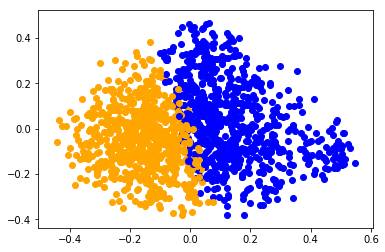

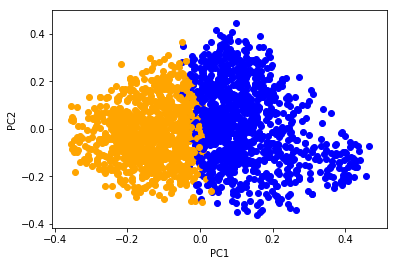

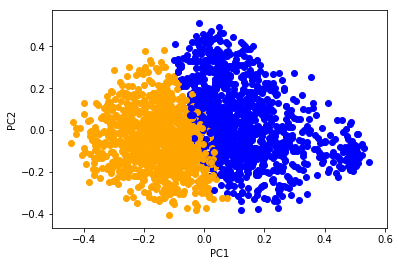

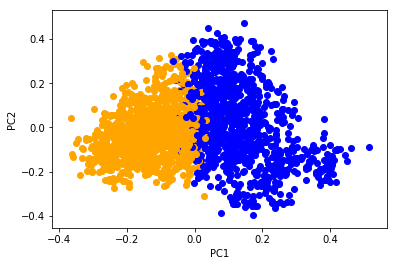

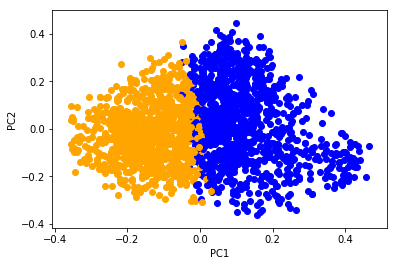

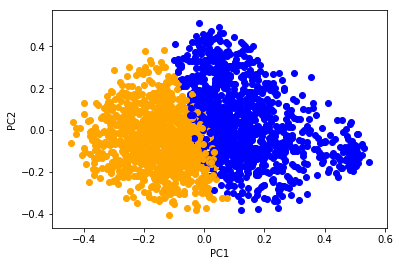

ValueError: object too deep for desired array

In [84]:
visualize_clusters(reduced_vectors_2, freq_nouns, dimensions, annotate, predictions_2)
visualize_clusters(reduced_vectors_5, freq_nouns, dimensions, annotate, predictions_5)
visualize_clusters(reduced_vectors_deps, freq_nouns, dimensions, annotate, predictions_deps)

In [14]:
#NOTE: THIS PART OF THE CODE IS TAKEN FROM ONE OF THE NLP1 LAB ASSIGNMENTS

# The perplixity used in t-SNE has significant effects on the resulting
# visualization. Generally, values in the range 5-30 work well. 
# If you have less data, or it is very high dimensional, you should go lower.
# If the data is packed closely together (lower dimension, more data), 
# then higher perplexity generally works better.


from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.palettes import d3
from bokeh.io import output_notebook
output_notebook()

def emb_scatter(data, names, perplexity=30.0, N=20):
    """
    Uses t-SNE with given perplexity to reduce the dimension of the 
    vectors in data to 2, plots these in a bokeh 2d scatter plot, 
    and colors them with N colors using K-means clustering of the 
    originial vectors. The colored dots are tagged with labels from
    the list names.
    
    :param data: numpy array of shape [num_vectors, embedding_dim]
    :param names: a list of words of length num_vectors in the same order as data
    :param perplexity: the perplexity for t-SNE
    :param N: the number of clusters to find by K-means
    """
    ## Try to find some clusters ##
    print("Finding clusters")
    kmeans = KMeans(n_clusters=N)
    kmeans.fit(data)
    klabels = kmeans.labels_

    ## Get a tsne fit ##
    print("Fitting tsne")
    tsne = TSNE(n_components=2, perplexity=perplexity)
    emb_tsne = tsne.fit_transform(data)
    
    ## Plot the tsne of the embeddings with bokeh ##
    # source: https://github.com/oxford-cs-deepnlp-2017/practical-1
    p = figure(tools="pan,wheel_zoom,reset,save",
               toolbar_location="above",
               title="T-SNE for most common words")

    # Set colormap as a list
    colormap = d3['Category20'][N]
    colors = [colormap[i] for i in klabels]

    source = ColumnDataSource(data=dict(x1=emb_tsne[:,0],
                                        x2=emb_tsne[:,1],
                                        names=names,
                                        colors=colors))

    p.scatter(x="x1", y="x2", size=8, source=source, color='colors')

    labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                      text_font_size="8pt", text_color="#555555",
                      source=source, text_align='center')
    p.add_layout(labels)

    show(p)

Loading BokehJS ...

In [25]:
emb_scatter(reduced_vectors_2[:100], freq_nouns[:100], perplexity=30.0, N=20)

Finding clusters
Fitting tsne


In [28]:
emb_scatter(reduced_vectors_5[:100], freq_nouns[:100], perplexity=30.0, N=20)

Finding clusters
Fitting tsne


In [29]:
emb_scatter(reduced_vectors_deps[:100], freq_nouns[:100], perplexity=30.0, N=20)

Finding clusters
Fitting tsne


In [30]:
emb_scatter(freq_vectors_2[:100], freq_nouns[:100], perplexity=30.0, N=20)

Finding clusters
Fitting tsne


In [31]:
emb_scatter(freq_vectors_5[:100], freq_nouns[:100], perplexity=30.0, N=20)

Finding clusters
Fitting tsne


In [32]:
emb_scatter(freq_vectors_deps[:100], freq_nouns[:100], perplexity=30.0, N=20)

Finding clusters
Fitting tsne
